<a href="https://colab.research.google.com/github/realsanjeev/image-captioning-using-machine-learning/blob/main/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import time
import os
import warnings
# for doing operation in gpu
import numpy as np
# for working in gpu numpy equivalent
# import cupy
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

from collections import Counter
from tensorflow.python.keras.backend import set_session
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
print(f"python {sys.version}")
print(f"Numpy version: {np.__version__}")
# print(f"cupy version: {np.__version__}")
print(f"padas vesion: {pd.__version__}")
print(f"keras version: {tf.keras.__version__}");
print(f"tensorflow version: {tf.__version__}")
print(f"tensorflow datasets version: {tfds.__version__}")

python 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
Numpy version: 1.22.4
padas vesion: 1.5.3
keras version: 2.12.0
tensorflow version: 2.12.0
tensorflow datasets version: 4.9.2


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
# Limiting GPU memory growth
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
# is cuda available
print(tf.test.is_built_with_cuda())

True


## Dataset loading
Dataset is loaded in cloud rather than ocal machine. Since it is more tedious to dowload the large data and process in local machine. The data is loaded from google cloud system

In [ ]:
BUFFER_SIZE = 1000
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"

trainds = tfds.load("coco_captions", split="train", data_dir= GCS_DIR)
sample_record = trainds.take(1)
print(sample_record)

<_TakeDataset element_spec={'captions': {'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'text': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>


In [ ]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
N_CHANNELS = 3
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)

In [ ]:
def get_image_with_caption(record):
  # get only one caption
  caption = record['captions']["text"][0]
  img = record['image']
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  img = img / 255
  return {"image_tensor": img, "caption": caption}

trainds = trainds.map(
  get_image_with_caption, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)

trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
trainds.element_spec

{'image_tensor': TensorSpec(shape=(299, 299, 3), dtype=tf.float32, name=None),
 'caption': TensorSpec(shape=(), dtype=tf.string, name=None)}

## Visualization

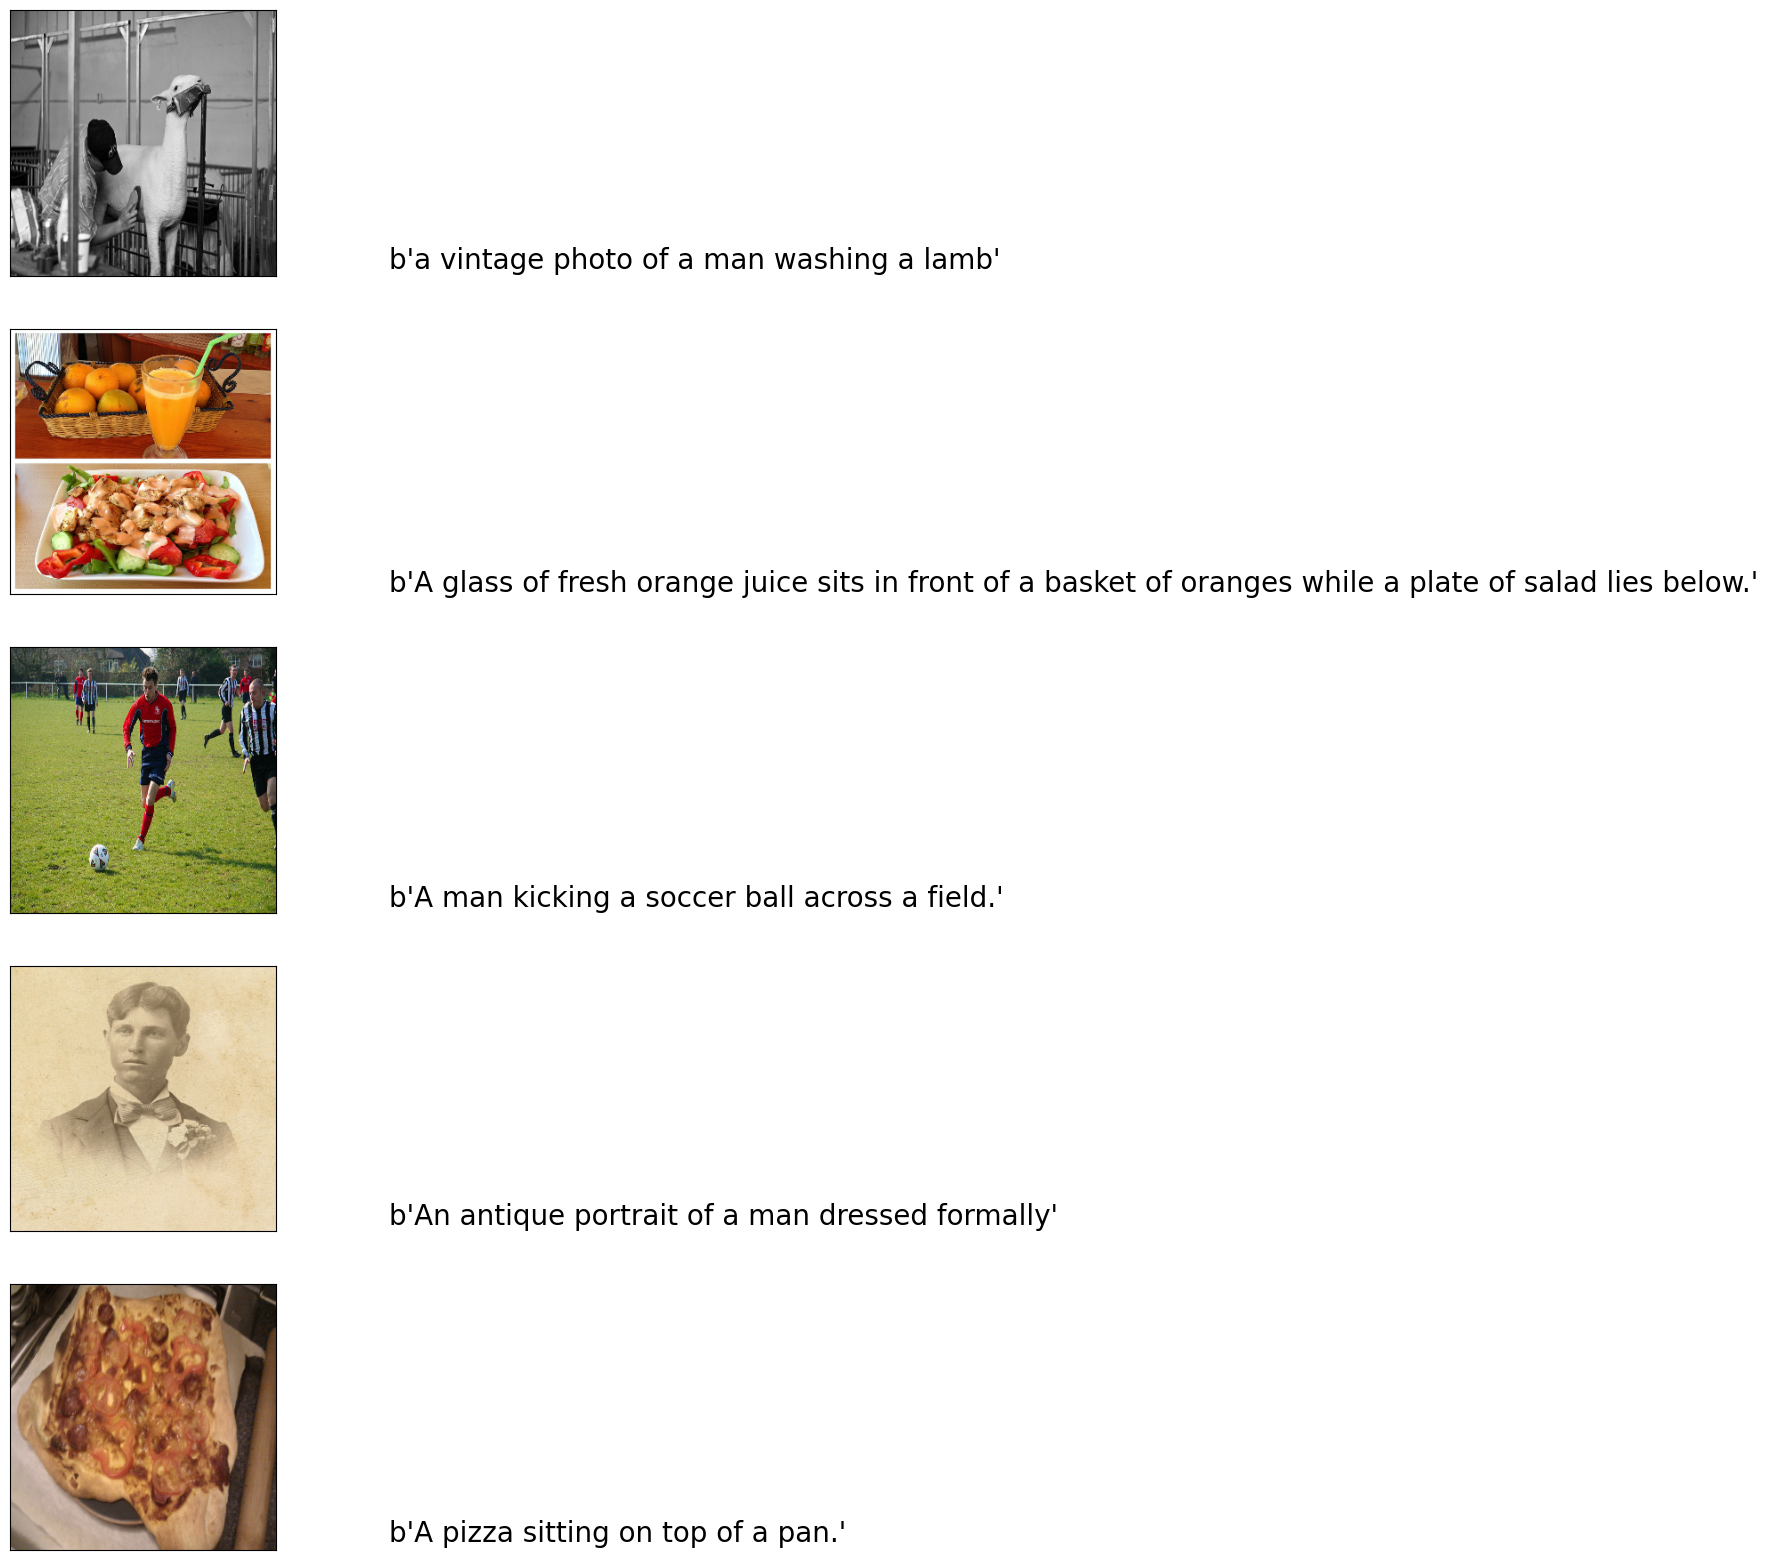

In [ ]:
npic = 5 # Displaying 5 images from the dataset

count = 1
fig = plt.figure(figsize=(10,20))
for record in trainds.take(npic):
  caption = record["caption"]
  image = record["image_tensor"]
  ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
  ax.imshow(image)
  count += 1

  ax = fig.add_subplot(npic, 2, count)
  plt.axis(False)
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(caption.numpy()))
  # for i, caption in enumerate(caption):
  ax.text(0, 1, caption.numpy(), fontsize=20)
  count += 1
plt.show()

In [ ]:
def add_start_end_token(data):
  start = tf.convert_to_tensor("startseq")
  end = tf.convert_to_tensor("endseq")
  data["caption"] = tf.strings.join([start, data["caption"], end],
                                    separator=" ")
  return data

trainds = trainds.map(add_start_end_token)

In [ ]:
MAX_CAPTION_LEN = 65
VOCAB_SIZE = 10000

def standardize(caption):
  caption = tf.strings.lower(caption)
  return tf.strings.regex_replace(
      caption, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
  )

# Use textvectorization
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN
)

tokenizer.adapt(trainds.map(lambda x: x["caption"]))
print("finished")

In [ ]:
for word_id in tokenizer(["startseq This is me from future colab using token endseq"])[0]:
  print(tokenizer.get_vocabulary()[word_id], end=" ")

In [ ]:
for i, data in enumerate(trainds.take(5)):
  caption = data["caption"]
  print(f"Sample Sentence {i}: {caption.numpy()}")
  print(f"Equivalent tokenized tensor {i}: {tokenizer(caption)}")

In [ ]:
print(f"Original sentence: {caption}")
print("Reconstructed sentence: ")
for word_id in tokenizer(caption).numpy():
  print(tokenizer.get_vocabulary()[word_id], end=" ")

In [ ]:
# string lookup word to id
word_to_idx = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)
# word_id to string
idx_to_word = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

## For training module to predict caption
To train a module for caption prediction, the tensor is shifted from right to left while maintaining the same target shape.

A simple analogy for this process is predicting the next word based on the previous words.

In [ ]:
BATCH_SIZE = 32

def create_ds_fn(data):
  image_tensor = data["image_tensor"]
  caption = tokenizer(data["caption"])

  # shift tensor right to left eg, [1, 2,3] => [2, 3]
  target = tf.roll(caption, -1, 0)
  zeros = tf.zeros([1], dtype=tf.int64)
  # mantain shape of target by adding zero element in last index
  target = tf.concat((target[:-1], zeros), axis=-1)
  return (image_tensor, caption), target

batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Feature Extractor
We use pretained model inception_resnet_v2 for extracting feature

In [ ]:
#
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
FEATURES_SHAPE = (8, 8, 1536)
FEATURE_EXTRACTOR.trainable = False
ATTENTION_DIM = 512

image_input = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = tf.keras.layers.Reshape((FEATURES_SHAPE[0]*FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(image_features)
encoder_output = tf.keras.layers.Dense(ATTENTION_DIM, activation="relu")(x)

encoder = tf.keras.Model(inputs=image_input,
                         outputs=encoder_output)

In [ ]:
encoder.summary()

In [ ]:
word_input = tf.keras.layers.Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = tf.keras.layers.Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = tf.keras.layers.GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = tf.keras.layers.Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = tf.keras.layers.Add()([gru_output, context_vector])

layer_norm = tf.keras.layers.LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = tf.keras.layers.Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

decoder = tf.keras.Model(
    inputs=[word_input, encoder_output],
    outputs=decoder_output
)
decoder.summary()

In [ ]:
tf.keras.utils.plot_model(decoder)

In [ ]:
image_caption_training_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)
tf.keras.utils.plot_model(image_caption_training_model)

## Defining loss function and compile

In [ ]:
loss_module = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction="none")

def loss_function(real, pred):
  loss_ = loss_module(real, pred)

  mask=tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=tf.int32)
  sentence_len = tf.reduce_sum(mask)
  loss_ = loss_[:sentence_len]

  return tf.reduce_mean(loss_, 1)

In [ ]:
image_caption_training_model.compile(
    optimizer="adam",
    loss=loss_function
)

### Wall time vs CPU time
> CPU time - the time actually spent by CPU executing method code.

> Wall time - the real-world time elapsed between a pair of events, e.g. between method entry and method exit

In [ ]:
%%time
history = image_caption_training_model.fit(batched_ds, epochs=1)

## Caption Prediction

In [ ]:
gru_state_input = tf.keras.layers.Input(
    shape=ATTENTION_DIM,
    name="GRU attention input"
)
# reusing the trained gru but update to receive the state
gru_output, gru_state = decoder_gru(
    embeded_x,
    initial_state=gru_state_input)

# reusing other layer
contex_vector=decoder_attention([gru_output, encoder_output])
addition_output = tf.keras.layer.Add()([
    gru_output, contex_vector
])
layer_norm_output = decoder_output_dense(layer_norm_output)

# defining the prediction model
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state]
)
tf.keras.utils.plot_model(decoder_pred_output)

In [ ]:
# predicting caption using trained model
def predict_caption(filename):
  gru_state = tf.zeros(1, ATTENTION_DIMS)

  img_tensor = tf.image.decode_jpeg(tf.io.read_file(filename))
  img_tensor = tf.image.resize(img_tensor, (IMG_HEIGHT, IMG_WIDTH))
  img_tensor = img_tensor / 255.0



  features = encoder(tf.expand_dims(img, axis=0))
  dec_input = tf.expand_dims([word_to_idx("startseq")], 1)
  results = []
  for i in range(MAX_CAPTION_LEN):
    predictations, gru_state = decoder_pred_model(
        [dec_input, gru_state, features]
    )

    # probabilistic distribution
    top_probs, top_idxs = tf.math.top_k(
        input=predictions[0][0], k=10, sorted=False
    )
    chosen_id = tf.random.categorical([top_probs], 1)
    predicted_id = top_idxs.numpy()[chosen_id][, ]

    result.append(tokenizer.get_vocabulary()[prediccted_id])
    if predicted_id == word_to_idx("endseq"):
      return img, result

    dec_input = tf.expand_dims([prediccted_id], 1)
  return img, result

In [ ]:
filename = "../sample_images/baseball.jpeg"  # you can also try surf.jpeg

for i in range(5):
  image, caption = predict_caption(filename)
  print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");